In [1]:
import numpy as np
import uproot

import matplotlib.pyplot as plt
plt.style.use('sensitivity.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def GetFullCut(tree):
    cut = np.where((tree['passed_xy_thresh'].array() == True) \
               & (tree['passed_z_thresh'].array() == True) \
               & (tree['n_x_ch_abovenoise'].array() > 0) \
               & (tree['n_y_ch_abovenoise'].array() > 0) \
               & (tree['m_nOPCal'].array() < (1.077*tree['m_nQ'].array()+313)) \
               & (tree['m_nOPCal'].array() > (0.597*tree['m_nQ'].array()-216)) \
               & (tree['standoff'].array() > 20.0) \
               & (tree['energy'].array() > 2435) \
               & (tree['energy'].array() < 2481) \
               & (tree['NESTBugFound'].array() == False) \
               & (tree['NearAnodeBugFound'].array() == False) \
              )
    return cut  

### Reading in data from ROOT files

In [3]:
bb0n = uproot.open("/gpfs/slac/staas/fs1/g/exo/exo_data8/exo_data/users/nexo_sensitivity2020/merged-v11/Baseline2019_bb0n_FullLXe.root")['tree']
u238 = uproot.open("/gpfs/slac/staas/fs1/g/exo/exo_data8/exo_data/users/nexo_sensitivity2020/merged-v11/Baseline2019_U238_TPCVessel.root")['tree']
th232 = uproot.open("/gpfs/slac/staas/fs1/g/exo/exo_data8/exo_data/users/nexo_sensitivity2020/merged-v11/Baseline2019_Th232_TPCVessel.root")['tree']

### Applying cuts

In [4]:
bb0n_cut = GetFullCut(bb0n)

In [5]:
th232_cut = GetFullCut(th232)

In [6]:
u238_cut = GetFullCut(u238)

### Getting the ROC curve

In [7]:
SignalEfficiency = []
BackgroundMisID_U238 = []
BackgroundMisID_Th232 = []

bb0n_events = np.array(bb0n['m_DNNvalue'].array()[bb0n_cut])
th232_events = np.array(th232['m_DNNvalue'].array()[th232_cut])
u238_events = np.array(u238['m_DNNvalue'].array()[u238_cut])

DNNVals = np.arange(0,1,0.01)
for x in DNNVals: 
    bb0n_dnn_cut = np.where(bb0n_events > x)
    th232_dnn_cut = np.where(th232_events > x)
    u238_dnn_cut = np.where(u238_events > x)

    signal = len(bb0n_events[bb0n_dnn_cut]) / len(bb0n_events)
    th232_bkg = len(th232_events[th232_dnn_cut]) / len(th232_events)
    u238_bkg = len(u238_events[u238_dnn_cut]) / len(u238_events)
    # print("%.2f" % x, "%.3f" % signal, "%.3f" % u238_bkg, "%.3f" % th232_bkg)
    
    SignalEfficiency.append(signal)
    BackgroundMisID_U238.append(u238_bkg)
    BackgroundMisID_Th232.append(th232_bkg)
    
SignalEfficiency = np.array(SignalEfficiency)
BackgroundMisID_U238 = np.array(BackgroundMisID_U238)
BackgroundMisID_Th232 = np.array(BackgroundMisID_Th232)

### Plotting the ROC curve

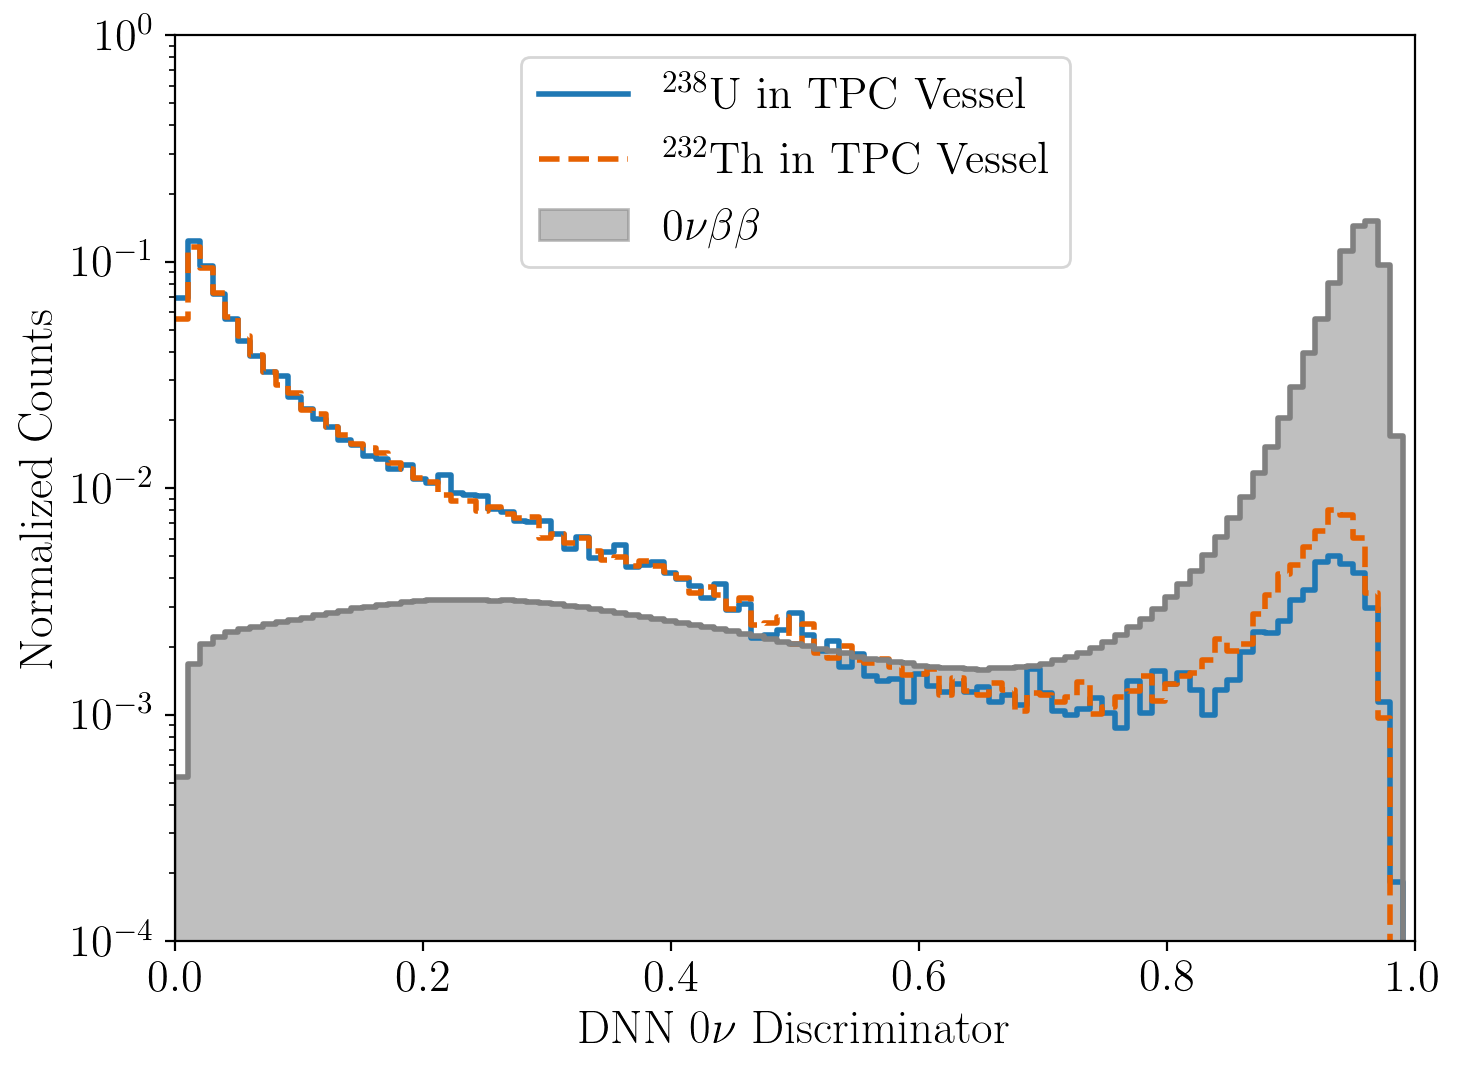

In [8]:
bb0n_hist, bb0n_histx = np.histogram(bb0n_events, bins=np.linspace(0,1,100))
th232_hist, th232_histx = np.histogram(th232_events, bins=np.linspace(0,1,100))
u238_hist, u238_histx = np.histogram(u238_events, bins=np.linspace(0,1,100))

plt.figure()
plt.xlim(0,1)
plt.ylim(1e-4,1e0)
plt.xlabel(r'DNN $0\nu$ Discriminator')
plt.ylabel('Normalized Counts')
plt.yscale('log')

plt.step(u238_histx[:-1], u238_hist/np.sum(u238_hist), where='post', label='${}^{238} \mathrm{U}$ in TPC Vessel')
plt.step(th232_histx[:-1], th232_hist/np.sum(th232_hist), where='post', ls='--', label='${}^{232} \mathrm{Th}$ in TPC Vessel')
plt.step(bb0n_histx[:-1], bb0n_hist/np.sum(bb0n_hist), ls='-', color='grey', where='post', label="", zorder=2)
plt.fill_between(bb0n_histx[:-1], bb0n_hist/np.sum(bb0n_hist), alpha=0.5, color='grey', step="post", label=r'$0 \nu\beta\beta$',zorder=1)

plt.legend(loc='upper center')
plt.show()

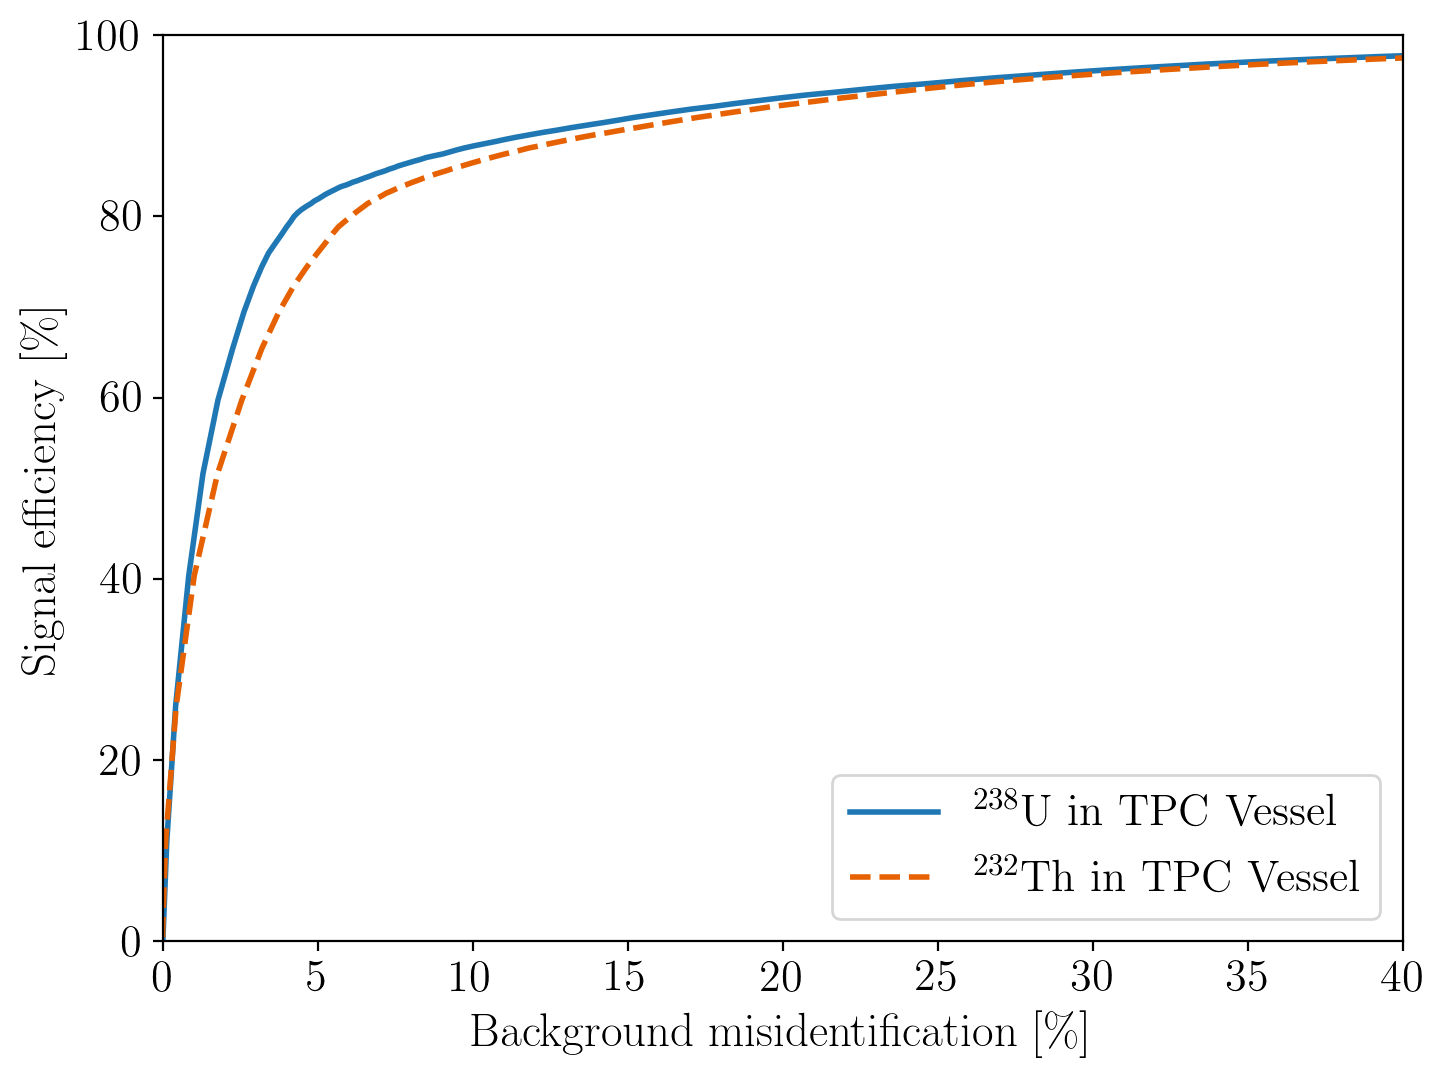

In [9]:
plt.figure()
plt.xlim(0,40)
plt.ylim(0,100)
plt.xlabel('Background misidentification [\%]')
plt.ylabel('Signal efficiency [\%]')

plt.plot(BackgroundMisID_U238*100, SignalEfficiency*100, color=colors[0], label='${}^{238} \mathrm{U}$ in TPC Vessel' )
plt.plot(BackgroundMisID_Th232*100, SignalEfficiency*100, color=colors[1], ls='--', label='${}^{232} \mathrm{Th}$ in TPC Vessel')
plt.legend(loc='lower right')
plt.show()

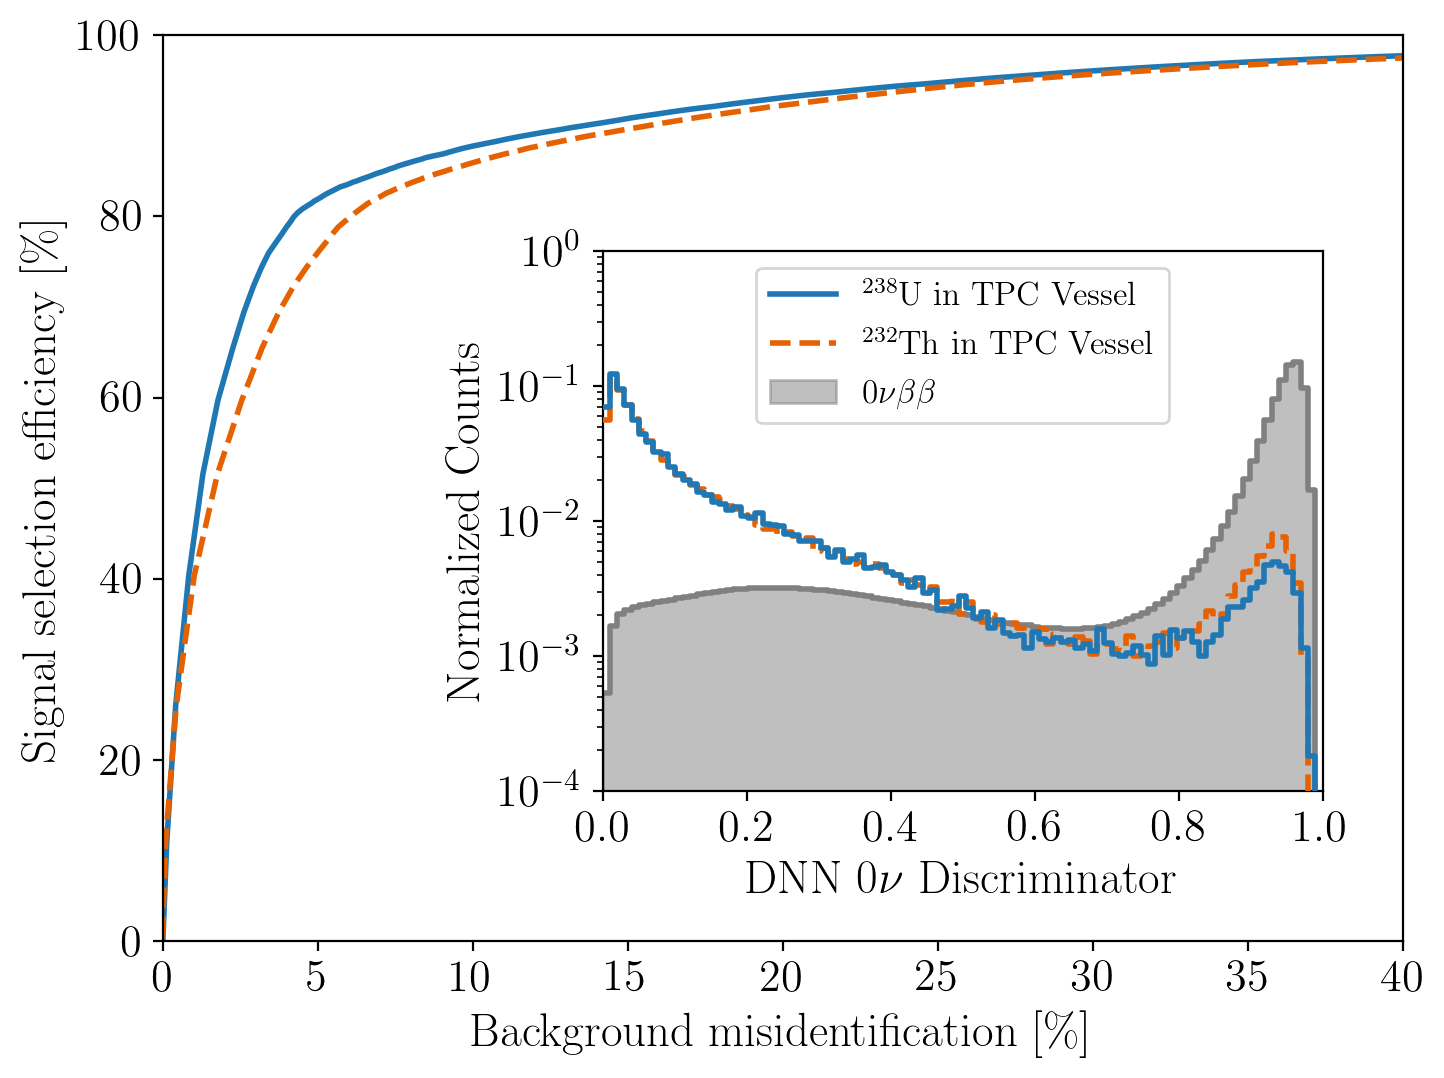

In [10]:
fig, ax1 = plt.subplots()

ax1.set_xlim(0,40)
ax1.set_ylim(0,100)
ax1.set_xlabel('Background misidentification [\%]')
ax1.set_ylabel('Signal selection efficiency [\%]')
ax1.plot(BackgroundMisID_U238*100, SignalEfficiency*100, color=colors[0],  label='${}^{238} \mathrm{U}$ in TPC Vessel' )
ax1.plot(BackgroundMisID_Th232*100, SignalEfficiency*100, color=colors[1], ls='--', label='${}^{232} \mathrm{Th}$ in TPC Vessel')

left, bottom, width, height = [0.4, 0.25, 0.45, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_yscale('log')
ax2.set_xlabel(r'DNN $0\nu$ Discriminator')
ax2.set_ylabel('Normalized Counts')

ax2.set_xlim(0,1)
ax2.set_ylim(1e-4,1e0)
ax2.step(u238_histx[:-1], u238_hist/np.sum(u238_hist), where='post',  label='${}^{238} \mathrm{U}$ in TPC Vessel',zorder=4)
ax2.step(th232_histx[:-1], th232_hist/np.sum(th232_hist), where='post', ls='--', label='${}^{232} \mathrm{Th}$ in TPC Vessel', zorder=3)
ax2.step(bb0n_histx[:-1], bb0n_hist/np.sum(bb0n_hist), ls='-', color='grey', where='post', label="", zorder=2)
ax2.fill_between(bb0n_histx[:-1], bb0n_hist/np.sum(bb0n_hist), alpha=0.5, color='grey', step="post", label=r'$0 \nu\beta\beta$',zorder=1)
ax2.legend(loc='upper center', fontsize=12)
plt.savefig('dnn_roc.png')
plt.show()